## DRILL: Prepare the Data

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR ([Thinkful mirror](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)).

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

The 'population' variable is already set for you, but you will need to create the last three features.  Robbery and Murder are currently continuous variables.  For this model, please use these variables to create  categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0.  You'll use this data and model in a later assignment- for now, just write the code you need to get the data ready.  Don't forget basic data cleaning procedures, either!  Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.


In [1]:
#necessary imports
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

In [2]:
#read in data
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', header=4)
print(df.columns)
df.head()

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861.000,0.000,0.000,nan,0.000,0.000,0.000,12.000,2.000,10.000,0.000,0.000
1,Addison Town and Village,2577.000,3.000,0.000,nan,0.000,0.000,3.000,24.000,3.000,20.000,1.000,0.000
2,Akron Village,2846.000,3.000,0.000,nan,0.000,0.000,3.000,16.000,1.000,15.000,0.000,0.000
3,Albany,97956.000,791.000,8.000,nan,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000,nan
4,Albion Village,6388.000,23.000,0.000,nan,3.000,4.000,16.000,223.000,53.000,165.000,5.000,nan


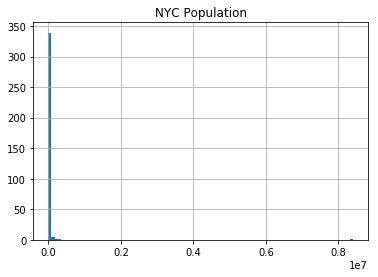

Median  7233.5
Std  450037.3675209857
Outliers above  907308.2350419714


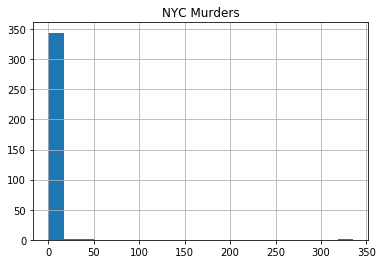

Median  0.0
Std  18.303672792887753
Outliers above  36.607345585775505


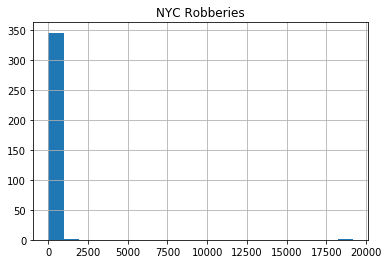

Median  1.0
Std  1031.0328732955247
Outliers above  2063.0657465910494


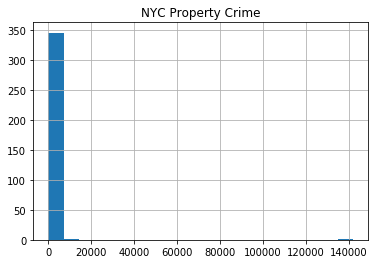

Median  112.5
Std  7659.724745633149
Outliers above  15431.949491266298


In [3]:
#plotting distributions of variables
df['Population'].hist(bins=100)
plt.title('NYC Population')
plt.show()

#calculating median, standard deviation and the limit for outliers
median = df.Population.median()
std = df.Population.std()
pop_out = median + 2* std

print('Median ', median)
print('Std ', std)
print('Outliers above ', pop_out)

df['Murder and\nnonnegligent\nmanslaughter'].hist(bins=20)
plt.title('NYC Murders')
plt.show()

median = df['Murder and\nnonnegligent\nmanslaughter'].median()
std = df['Murder and\nnonnegligent\nmanslaughter'].std()
mur_out = median + 2* std

print('Median ', median)
print('Std ', std)
print('Outliers above ', mur_out)

df['Robbery'].hist(bins=20)
plt.title('NYC Robberies')
plt.show()

median = df.Robbery.median()
std = df.Robbery.std()
rob_out = median + 2* std

print('Median ', median)
print('Std ', std)
print('Outliers above ', rob_out)

df['Property\ncrime'].hist(bins=20)
plt.title('NYC Property Crime')
plt.show()

median = df['Property\ncrime'].median()
std = df['Property\ncrime'].std()
prop_out = median + 2* std

print('Median ', median)
print('Std ', std)
print('Outliers above ', prop_out)

Clearly some outliers in the dataset that need to be removed.

In [4]:
#turning outliers into None
df['Population'] = df.Population.map(lambda x: x if x < pop_out else None)
df['Murder and\nnonnegligent\nmanslaughter'] = df['Murder and\nnonnegligent\nmanslaughter'].map(lambda x: x if x < mur_out else None)
df['Robbery'] = df.Robbery.map(lambda x: x if x < rob_out else None)
df['Property\ncrime'] = df['Property\ncrime'].map(lambda x: x if x < prop_out else None)

In [5]:
#examining highest values in each category.  
print(df.Population.dropna().sort_values(ascending=False).head())
print(df['Murder and\nnonnegligent\nmanslaughter'].dropna().sort_values(ascending=False).head())
print(df.Robbery.dropna().sort_values(ascending=False).head())
print(df['Property\ncrime'].dropna().sort_values(ascending=False).head())

35    258789.000
272   210562.000
346   199134.000
310   143834.000
7     118296.000
Name: Population, dtype: float64
310   21.000
140   10.000
3      8.000
285    8.000
321    7.000
Name: Murder and\nnonnegligent\nmanslaughter, dtype: float64
35    1322.000
272    918.000
310    400.000
346    390.000
206    228.000
Name: Robbery, dtype: float64
35    12491.000
272   10051.000
310    6473.000
3      4090.000
218    2807.000
Name: Property\ncrime, dtype: float64


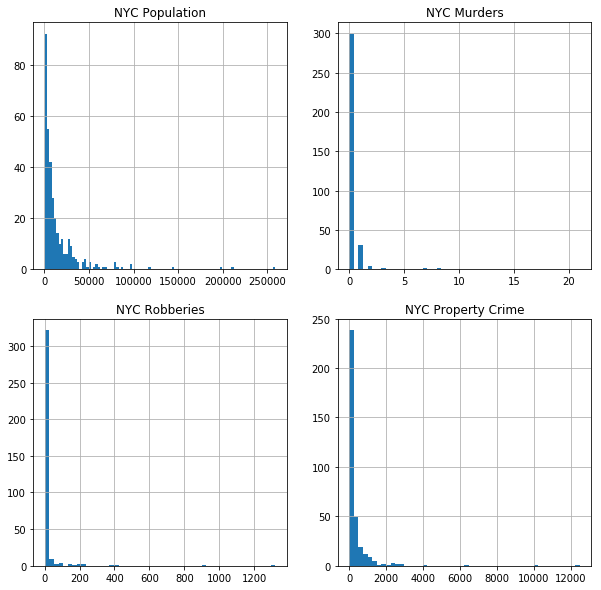

In [6]:
#re-plotting post-outlier-removal
plt.figure(figsize=(10,10))
plt.subplot(221)
df['Population'].hist(bins=100)
plt.title('NYC Population')

plt.subplot(222)
df['Murder and\nnonnegligent\nmanslaughter'].hist(bins=50)
plt.title('NYC Murders')

plt.subplot(223)
df['Robbery'].hist(bins=50)
plt.title('NYC Robberies')

plt.subplot(224)
df['Property\ncrime'].hist(bins=50)
plt.title('NYC Property Crime')

plt.show()

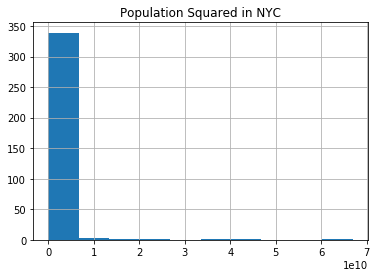

In [7]:
#creating population squared feature
df['PopSq'] = df['Population']**2
df['PopSq'].hist()
plt.title('Population Squared in NYC')
plt.show()

In [8]:
#turning murder and robbery into categorical features
df['Murder_cat'] = df['Murder and\nnonnegligent\nmanslaughter'].dropna().map(lambda x: 1 if x > 0 else 0)
df['Robbery_cat'] = df.Robbery.dropna().map(lambda x: 1 if x > 0 else 0)
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,PopSq,Murder_cat,Robbery_cat
0,Adams Village,1861.000,0.000,0.000,nan,0.000,0.000,0.000,12.000,2.000,10.000,0.000,0.000,3463321.000,0.000,0.000
1,Addison Town and Village,2577.000,3.000,0.000,nan,0.000,0.000,3.000,24.000,3.000,20.000,1.000,0.000,6640929.000,0.000,0.000
2,Akron Village,2846.000,3.000,0.000,nan,0.000,0.000,3.000,16.000,1.000,15.000,0.000,0.000,8099716.000,0.000,0.000
3,Albany,97956.000,791.000,8.000,nan,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000,nan,9595377936.000,1.000,1.000
4,Albion Village,6388.000,23.000,0.000,nan,3.000,4.000,16.000,223.000,53.000,165.000,5.000,nan,40806544.000,0.000,1.000


In [9]:
#isolating data to be used for modeling
data = df[['Population', 'PopSq', 'Murder_cat', 'Robbery_cat', 'Property\ncrime']].dropna()
data.head()

,Population,PopSq,Murder_cat,Robbery_cat,Property crime
0,1861.000,3463321.000,0.000,0.000,12.000
1,2577.000,6640929.000,0.000,0.000,24.000
2,2846.000,8099716.000,0.000,0.000,16.000
3,97956.000,9595377936.000,1.000,1.000,4090.000
4,6388.000,40806544.000,0.000,1.000,223.000


In [10]:
#Instantiate and fit the model
regr = linear_model.LinearRegression()
Y = data['Property\ncrime']
X = data[['Population', 'PopSq', 'Murder_cat', 'Robbery_cat']]
regr.fit(X, Y)

#inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n')
print(regr.score(X, Y))


Coefficients: 
 [ 2.62320223e-02 -3.30058846e-08  1.70080551e+02  1.27606800e+01]

Intercept: 
 -70.88477571593813

R-squared: 

0.7135336089794011


This R-squared value of 0.714 is not bad as a first pass of our model.

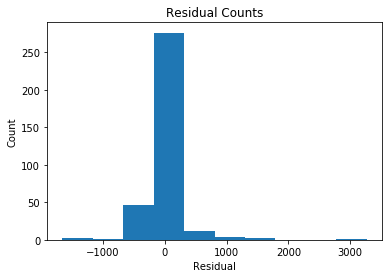

In [11]:
# Extract predicted values
predicted = regr.predict(X).ravel()
actual = data['Property\ncrime']

#calculate residual
residual = actual - predicted

plt.hist(residual)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Counts')
plt.show()

This looks fairly normally distributed, with some skew towards higher residuals.

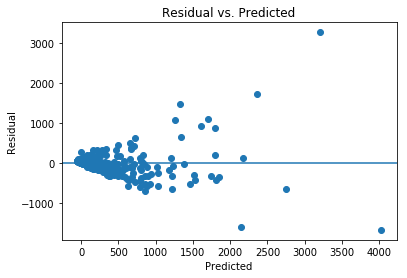

In [12]:
#plotting for homoscedasicity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

This looks like there is no real pattern in residual vs predicted.  The data is evenly distributed over the residual

In [13]:
#identifying correlations among features
correlation_matrix = X.corr()
display(correlation_matrix)

,Population,PopSq,Murder_cat,Robbery_cat
Population,1.000,0.870,0.500,0.391
PopSq,0.870,1.000,0.354,0.187
Murder_cat,0.500,0.354,1.000,0.305
Robbery_cat,0.391,0.187,0.305,1.000


Obviously population and population squared are highly correlated.  Murder is moderately correlated with population.

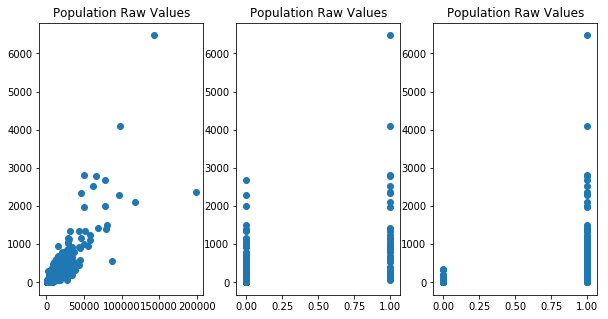

In [14]:
#plotting features vs output
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.scatter(X['Population'], Y)
plt.title('Population Raw Values')

plt.subplot(132)
plt.scatter(X['Murder_cat'], Y)
plt.title('Population Raw Values')

plt.subplot(133)
plt.scatter(X['Robbery_cat'], Y)
plt.title('Population Raw Values')
plt.show()

These look mostly linear.